<a href="https://colab.research.google.com/github/sanjeevr5/CV/blob/main/Torch_CV_Series_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Custom CNN With Torch

<b> Dataset used </b> : Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1
<b> Input Data Format </b> : ./folder/classname####.jpg where # represents a number

In [ ]:
%%capture
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
!unzip /content/4drtyfjtfy-1.zip
!unzip /content/dataset2.zip

In [ ]:
!ls dataset2 | wc -l

1125


There are a total of 1125 images in the folder

In [ ]:
import os
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import cv2
import torch
import torchvision
from torchvision.utils import make_grid
SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)
device = ('cuda' if torch.cuda.is_available else 'cpu')
torch.backends.cudnn.deterministic = True

In [ ]:
def load_image(path, img_size = (128,128), l = True):
  h,w = img_size
  label = re.findall(r'[a-z]+', path.split('/')[-1])[0]
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) #CV2 reads in BGR and we have to convert it into RGB(general format)
  img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
  if l:
    return img, label
  return img
  

def display_imgs(path):
  imgs = [load_image(p, l = False) for p in path]
  imgs = torch.as_tensor(imgs) #batch, h, w, c
  imgs = imgs.permute(0, 3, 1, 2) # Batch, Channels, Height, Width
  grid_images = make_grid(imgs, nrow = 5) # Returns B, H, W
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_images.permute(1, 2, 0)) #because MPL needs channel as the last dimension
  plt.axis('off')

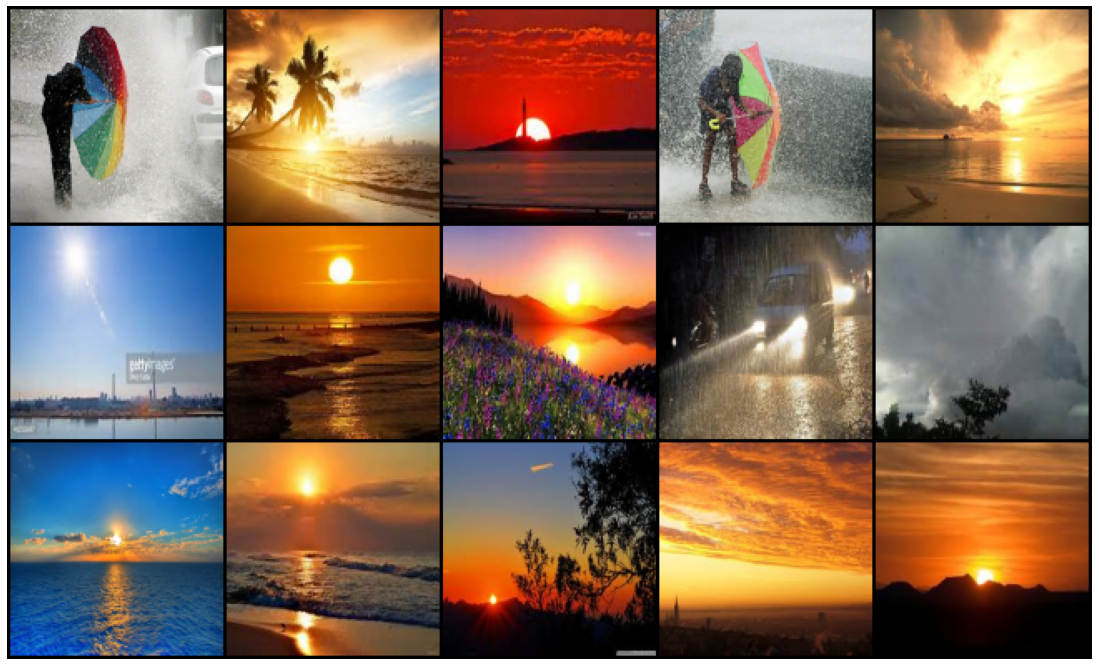

In [ ]:
sample_imgs = ['./dataset2/'+i for i in np.random.choice(os.listdir('./dataset2'), 15)]
display_imgs(sample_imgs)

In [ ]:
file_dict = {}
for img_name in os.listdir('./dataset2'):
  clss_name = re.findall(r'[a-z]+', img_name.split('/')[-1])[0]
  if file_dict.get(clss_name, None):
    file_dict[clss_name].append(f'./dataset2/{img_name}')
  else:
    file_dict[clss_name] = [f'./dataset2/{img_name}']

print(f'Unique labels are : {file_dict.keys()}')

Unique labels are : dict_keys(['sunrise', 'cloudy', 'rain', 'shine'])


In [ ]:
!rm -r data
DATA_DIR = Path('./data')
DATASETS = ['train', 'test']
for ds in DATASETS:
  for cl in file_dict.keys():
    Path(DATA_DIR / ds / cl).mkdir(parents=True, exist_ok=True)

rm: cannot remove 'data': No such file or directory


In [ ]:
for clss in file_dict:
  paths = np.array(file_dict[clss])
  np.random.shuffle(paths)
  ds_split = np.split(paths, indices_or_sections=[int(.8*len(paths))])
  print(f'"{clss} name" -> Total size : {len(paths)} ; Train Size : {len(ds_split[0])} ; Test Size : {len(ds_split[1])}')
  dataset = zip(DATASETS, ds_split)
  for ds, pa in dataset:
    for path in pa:
      shutil.copy(path, f'{DATA_DIR}/{ds}/{clss}/')
  print(f'{clss} copy complete!')

"sunrise name" -> Total size : 357 ; Train Size : 285 ; Test Size : 72
sunrise copy complete!
"cloudy name" -> Total size : 300 ; Train Size : 240 ; Test Size : 60
cloudy copy complete!
"rain name" -> Total size : 215 ; Train Size : 172 ; Test Size : 43
rain copy complete!
"shine name" -> Total size : 253 ; Train Size : 202 ; Test Size : 51
shine copy complete!


In [ ]:
from torch import nn, optim
from torchvision import transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

mean_nums = [0.485, 0.456, 0.406] #ImageNet means since we use transfer learning
std_nums = [0.229, 0.224, 0.225] #ImageNet standard dev since we use transfer learning
i_transform = {'train' : transforms.Compose([
                                             transforms.Resize(size = (64,64)), #resize(size = 64) can be used only when h = w
                                             transforms.RandomRotation(degrees = 25),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean_nums, std_nums)
]), 'test' : transforms.Compose([
                                 transforms.Resize(size= (64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_nums, std_nums)
])}

In [ ]:
image_datasets = {d: ImageFolder(f'{DATA_DIR}/{d}', i_transform[d]) for d in DATASETS}
image_dataloaders = {d : DataLoader(image_datasets[d], batch_size = 4, shuffle=True, num_workers=4) for d in DATASETS}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes # Only when using the ImageFolder
dataset_sizes

{'test': 226, 'train': 899}

# Calculating no. of neurons for conv2D to linear
![Dilation](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/dilation.gif)
The above image represents the dilation

In [ ]:
class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 13 * 13, 120) #26 * 26 is the output image we get from the conv2
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13) #-1 is specified if we are unsure about the number of rows but sure of the number of columns
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CustomCNN()
print('The number of trainable parameters are :', sum(p.numel() for p in net.parameters() if p.requires_grad))
#https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch

The number of trainable parameters are : 338486


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()
model = net.to(device)
criterion = criterion.to(device)

In [ ]:
def accuracy(preds, true):
  _, index = torch.max(preds, dim = 1)
  return (index == true).sum().float() / len(preds)

def train_m(model, data_loader, loss_fn, optims):
  model.train()
  e_loss, e_acc = 0, 0
  for inputs, labels in data_loader:
    optimizer.zero_grad()
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    acc = accuracy(outputs,  labels)
    loss = loss_fn(outputs.squeeze(1), labels.long())
    loss.backward()
    optims.step()
    e_loss += loss.item()
    e_acc += acc.item()
  return e_loss/len(data_loader), e_acc/len(data_loader)

def evaluate_m(model, data_loader, loss_fn):
  e_loss, e_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(1), labels.long())
      acc = accuracy(outputs,  labels)
      e_loss += loss.item()
      e_acc += acc.item()
  return e_loss/len(data_loader), e_acc/len(data_loader)

In [ ]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_m(model, image_dataloaders['train'], criterion, optimizer)
    valid_loss, valid_acc = evaluate_m(model, image_dataloaders['test'], criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} / {N_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 / 5 | Epoch Time: 0m 9s
	Train Loss: 0.799 | Train Acc: 69.00%
	 Val. Loss: 0.672 |  Val. Acc: 74.12%
Epoch: 02 / 5 | Epoch Time: 0m 9s
	Train Loss: 0.543 | Train Acc: 78.00%
	 Val. Loss: 0.526 |  Val. Acc: 78.07%
Epoch: 03 / 5 | Epoch Time: 0m 9s
	Train Loss: 0.518 | Train Acc: 78.63%
	 Val. Loss: 0.517 |  Val. Acc: 79.39%
Epoch: 04 / 5 | Epoch Time: 0m 9s
	Train Loss: 0.456 | Train Acc: 83.11%
	 Val. Loss: 0.842 |  Val. Acc: 67.98%
Epoch: 05 / 5 | Epoch Time: 0m 9s
	Train Loss: 0.480 | Train Acc: 81.04%
	 Val. Loss: 0.675 |  Val. Acc: 73.68%
